# Import and prepare Notebook Environement

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score


In [2]:
sys.path.append(os.path.abspath("../src/"))

In [3]:
from EmbVector import Vector

## **CNN Model**
## Getting datas
**sim_gene_var mode** : The "Sum" colum of datas is the sum of vector Variation and vector Gene and all `top_number` vectors most similar to Variation and Gene without the vector of other existing variation for the gene

> **Formula**
>
> Sum = vect_Variation + vect_Gene + sum(most_similar(`top_number`) for Gene and Variation) - sum(vect_other_variation_for_gene) 

In [4]:
def get_model(is_balanced):
    if is_balanced:
        path = "../datas/cbow_A3316_WS20_E20_B10000_R2000_CTrue.model"
    else:
        path = "../datas/cbow_3284.model"
    return path

In [5]:
datas = Vector(data_file = "../datas/training_clean", 
        model_path = get_model(is_balanced = True), 
        is_training = True)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas.get_vector_datas(is_notebook = True, type_sum =  "sim_gene_var")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 688
____________________________________________________________________
Getting vectors finished in 88.94141498500176 seconds


In [6]:
datas_unbalanced = Vector(data_file = "../datas/training_clean", 
        model_path = get_model(is_balanced = False), 
        is_training = True)
# type_sum values : gene_var, best_sim, clean_art, sim_gene_var
# top_number only use with best_sim or sim_gene_var, defautl = 50
datas_unbalanced.get_vector_datas(is_notebook = True, type_sum =  "sim_gene_var")

________________________Getting datas vectors_______________________
____________________________________________________________________
Number of genes/variations not foud : 841
____________________________________________________________________
Getting vectors finished in 85.58049256199956 seconds


## Split the datas
Spliting the datas from the first model (without new articles) by 80% for training, and 20% fort test

In [6]:
X = datas.vectors[['Gene','Variation','Sum']]
Y = pd.get_dummies(datas.vectors["Class"]).values

#X = datas_unbalanced.vectors[['Gene','Variation','Sum']]
#Y = pd.get_dummies(datas_unbalanced.vectors["Class"]).values

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print("X_train : " + str(X_train.shape))
print("Y_train : " + str(Y_train.shape))
print("X_test : " + str(X_test.shape))
print("Y_test : " + str(Y_test.shape))

X_train : (2651, 3)
Y_train : (2651, 9)
X_test : (663, 3)
Y_test : (663, 9)


## CNN Model with all datas separated
Using all Gene, Variation, Sum datas but separated into different variable

In [8]:
X_train_gene = X_train["Gene"]
X_train_var = X_train["Variation"]
X_train_sum = X_train["Sum"]
X_test_gene = X_test["Gene"]
X_test_var = X_test["Variation"]
X_test_sum = X_test["Sum"]

In [9]:
X_train_gene = X_train_gene.values.reshape(X_train_gene.shape[0], 1)
X_train_var = X_train_var.values.reshape(X_train_var.shape[0], 1)
X_train_sum = X_train_sum.values.reshape(X_train_sum.shape[0], 1)

X_test_gene = X_test_gene.values.reshape(X_test_gene.shape[0], 1)
X_test_var = X_test_var.values.reshape(X_test_var.shape[0], 1)
X_test_sum = X_test_sum.values.reshape(X_test_sum.shape[0], 1)

## Preparing the datas for the input of the model
It is needed to convert the datas to have a clean numpy array and not a mix of object dataframe and array

In [10]:
def convert_to_np_gene(Object):
    np_list = []
    for obj in Object:
        cop = obj[0].copy()
        np_list.append(np.array(cop))
    return np.array(np_list)

def convert_to_np_var_sum(Object):
    np_list = []
    for obj in Object:
        for o in obj:
            cop = o[0].copy()
            np_list.append(np.array(cop))
    return np.array(np_list)

In [11]:
X_train_gene = convert_to_np_gene(X_train_gene)
X_train_var = convert_to_np_var_sum(X_train_var)
X_train_sum = convert_to_np_var_sum(X_train_sum)

X_test_gene = convert_to_np_gene(X_test_gene)
X_test_var = convert_to_np_var_sum(X_test_var)
X_test_sum = convert_to_np_var_sum(X_test_sum)

In [12]:
print("X_train_gene : " + str(X_train_gene.shape))
print("X_train_var : " + str(X_train_var.shape))
print("X_train_sum : " + str(X_train_sum.shape))

print("X_test_gene : " + str(X_test_gene.shape))
print("X_test_var : " + str(X_test_var.shape))
print("X_test_sum : " + str(X_test_sum.shape))

print("Y_train : " + str(Y_train.shape))
print("Y_test : " + str(Y_test.shape))

X_train_gene : (2651, 100)
X_train_var : (2651, 100)
X_train_sum : (2651, 100)
X_test_gene : (663, 100)
X_test_var : (663, 100)
X_test_sum : (663, 100)
Y_train : (2651, 9)
Y_test : (663, 9)


In [13]:
X_train_gene = X_train_gene.reshape(X_train_gene.shape[0],X_train_gene.shape[1], 1)
X_train_var = X_train_var.reshape(X_train_var.shape[0], X_train_var.shape[1], 1)
X_train_sum = X_train_sum.reshape(X_train_sum.shape[0], X_train_sum.shape[1], 1)

X_test_gene = X_test_gene.reshape(X_test_gene.shape[0], X_test_gene.shape[1], 1)
X_test_var = X_test_var.reshape(X_test_var.shape[0], X_test_var.shape[1], 1)
X_test_sum = X_test_sum.reshape(X_test_sum.shape[0], X_test_sum.shape[1], 1)

In [13]:
print("X_train_gene : " + str(X_train_gene.shape))
print("X_train_var : " + str(X_train_var.shape))
print("X_train_sum : " + str(X_train_sum.shape))

print("X_test_gene : " + str(X_test_gene.shape))
print("X_test_var : " + str(X_test_var.shape))
print("X_test_sum : " + str(X_test_sum.shape))

print("Y_train : " + str(Y_train.shape))
print("Y_test : " + str(Y_test.shape))

X_train_gene : (2651, 100, 1)
X_train_var : (2651, 100, 1)
X_train_sum : (2651, 100, 1)
X_test_gene : (663, 100, 1)
X_test_var : (663, 100, 1)
X_test_sum : (663, 100, 1)
Y_train : (2651, 9)
Y_test : (663, 9)


## **Building the model with Gene, Variation and Sum datas**

## Model 1 : Simple

In [18]:
def create_model_simple():
    input_gene = layers.Input(shape=(X_train_gene.shape[1], X_train_gene.shape[2]))
    input_variant = layers.Input(shape=(X_train_var.shape[1], X_train_gene.shape[2]))
    input_sum = layers.Input(shape=(X_train_sum.shape[1], X_train_gene.shape[2]))


    conv_gene = layers.Conv1D(32, kernel_size=(3), activation='relu')(input_gene)
    conv_var = layers.Conv1D(32, kernel_size=(3), activation='relu')(input_variant)
    conv_sum = layers.Conv1D(32, kernel_size=(3), activation='relu')(input_sum)

    input_2 = layers.Concatenate(axis = 1)([conv_gene, conv_var, conv_sum])

    dense_1 = layers.Dense(16, activation='relu')(input_2)
    flatten = layers.Flatten()(dense_1)
    output = layers.Dense(9, activation='softmax')(flatten)

    return keras.Model(inputs = [input_gene, input_variant, input_sum], outputs = output)

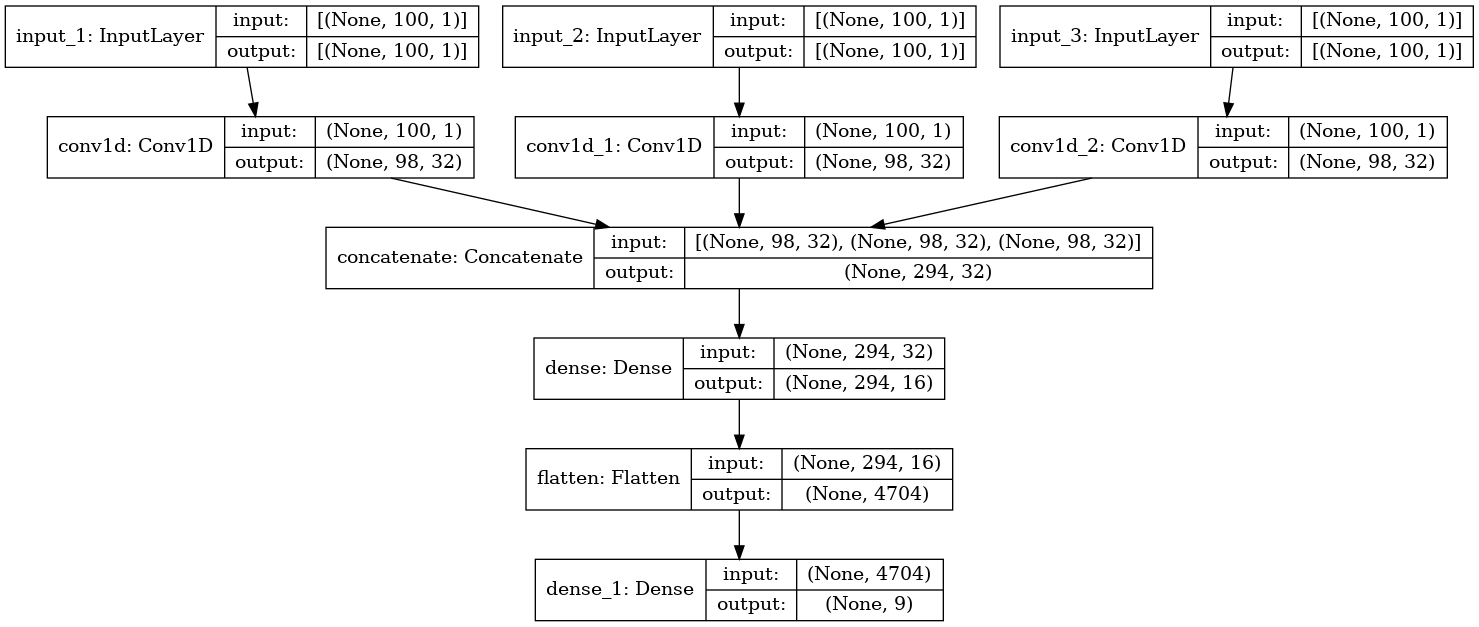

In [19]:
model_simple = create_model_simple()
model_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_simple, "CNN_W2V_Separate_Simple_gv_gv.png", show_shapes= True)

## Model 2 : Complex

In [20]:
def create_model_complex():
    input_gene = layers.Input(shape=(X_train_gene.shape[1], X_train_gene.shape[2]))
    input_variant = layers.Input(shape=(X_train_var.shape[1], X_train_gene.shape[2]))
    input_sum = layers.Input(shape=(X_train_sum.shape[1], X_train_gene.shape[2]))
    
    
    conv_gene = layers.Conv1D(64, kernel_size=(3), activation='relu')(input_gene)
    conv_var = layers.Conv1D(64, kernel_size=(3), activation='relu')(input_variant)
    conv_sum = layers.Conv1D(64, kernel_size=(3), activation='relu')(input_sum)
    
    pool_gene = layers.GlobalMaxPooling1D()(conv_gene)
    pool_var = layers.GlobalMaxPooling1D()(conv_var)
    pool_sum = layers.GlobalMaxPooling1D()(conv_sum)
    
    
    dense_gene = layers.Dense(64, activation='relu')(pool_gene)
    dense_var = layers.Dense(64, activation='relu')(pool_var)
    dense_sum = layers.Dense(64, activation='relu')(pool_sum)
    
    
    input_2 = layers.Concatenate(axis = 1)([dense_gene, dense_var, dense_sum])
    dense = layers.Dense(32, activation='relu')(input_2)
    dense_1 = layers.Dense(16, activation='relu')(dense)
    flatten = layers.Flatten()(dense_1)
    output = layers.Dense(9, activation='softmax')(flatten)
    
    
    return keras.Model(inputs = [input_gene, input_variant, input_sum], outputs = output)

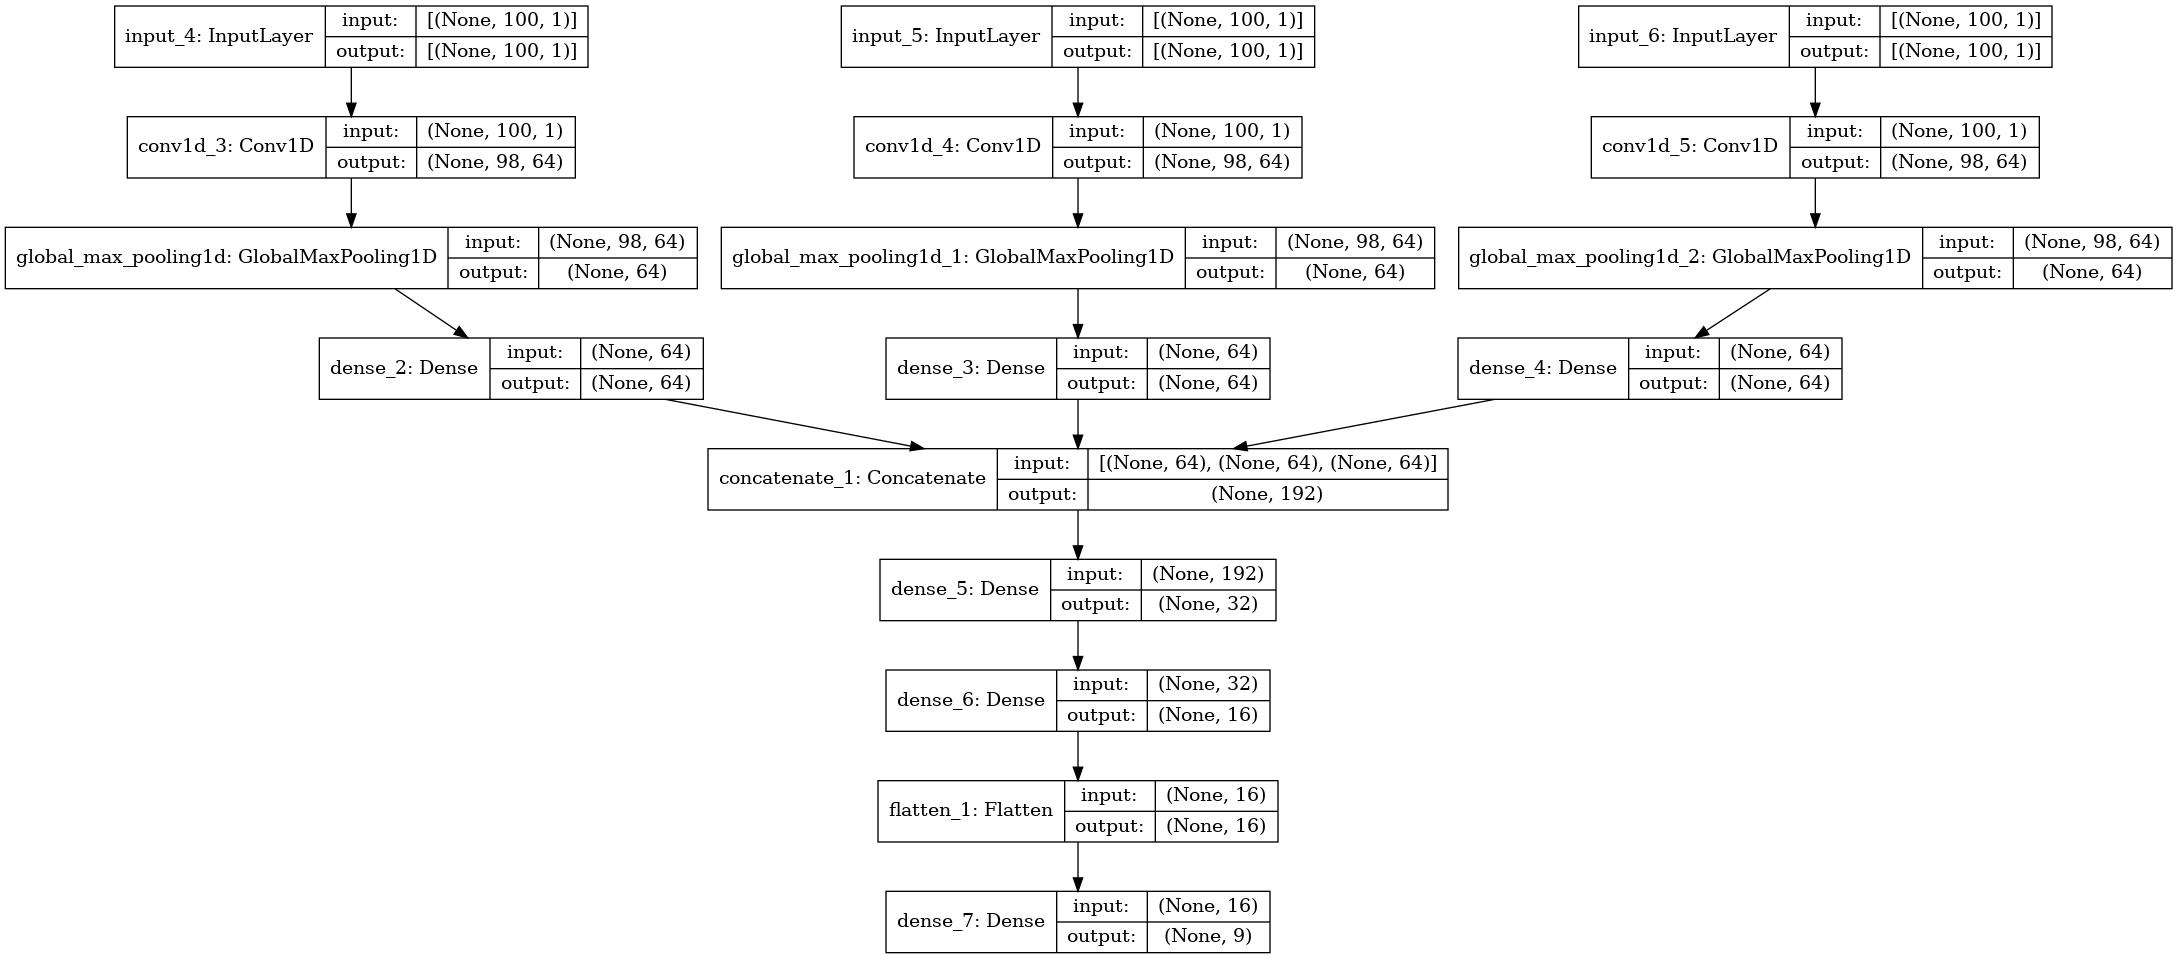

In [21]:
model_complex = create_model_complex()
model_complex.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
keras.utils.plot_model(model_complex, "CNN_W2V_Separate_Complex_sgv.png", show_shapes= True)

## **Training**

## Model 1 : Simple

In [22]:
history_simple = model_simple.fit([X_train_gene, X_train_var, X_train_sum], Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [23]:
loss, accuracy = model_simple.evaluate([X_train_gene, X_train_var, X_train_sum], Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 64.617 %


In [24]:
loss, accuracy = model_simple.evaluate([X_test_gene, X_test_var, X_test_sum], Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  56.410 %


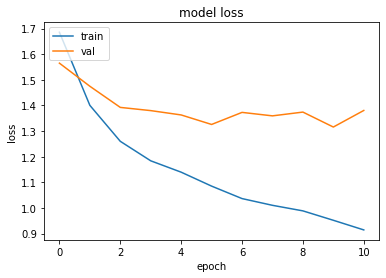

In [25]:
# summarize history for loss
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## Model 2 : Complex

In [26]:
history_complex = model_complex.fit([X_train_gene, X_train_var, X_train_sum], Y_train,
                     epochs=50,
                     verbose=False,
                     validation_split = 0.2,
                     batch_size= 32, 
                     callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
)

In [27]:
loss, accuracy = model_complex.evaluate([X_train_gene, X_train_var, X_train_sum], Y_train, verbose=False)
print("Training Accuracy: %.3f %%"  % (accuracy * 100.0))

Training Accuracy: 47.454 %


In [28]:
loss, accuracy = model_complex.evaluate([X_test_gene, X_test_var, X_test_sum], Y_test, verbose=False)

print("Testing Accuracy:  %.3f %%"  % (accuracy * 100.0))

Testing Accuracy:  47.511 %


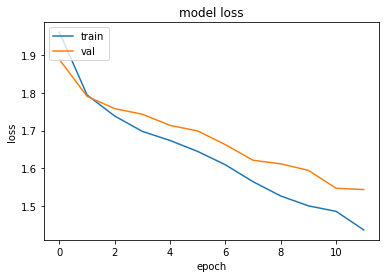

In [29]:
# summarize history for loss
plt.plot(history_complex.history['loss'])
plt.plot(history_complex.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## **Saving models**

In [30]:
model_simple.save("../results/Models/CNN_W2V_simple_Separate_datas_sgv.model")

2021-10-25 15:46:50.916742: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../results/Models/CNN_W2V_simple_Separate_datas_sgv.model/assets


In [31]:
model_complex.save("../results/Models/CNN_W2V_complex_Separate_datas_sgv.model")

INFO:tensorflow:Assets written to: ../results/Models/CNN_W2V_complex_Separate_datas_sgv.model/assets


__________________________________

# Clear the Session and delete model

In [28]:
keras.backend.clear_session()
del model_simple
del model_complex

__________________________________

__________________________________

# **Confusion matrix**

In [14]:
def plot_matrices(model, x_test, y_test):
  probas = model.predict(x_test)
  pred_indices = np.argmax(probas, axis=1)
  classes = np.array(range(1, 10))
  preds = classes[pred_indices]
  print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
  print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds))) 

  confusion  = confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)
  precision =(confusion/confusion.sum(axis=0))
  recall =(((confusion.T)/(confusion.sum(axis=1))).T)
  f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6)) 
  labels = [1,2,3,4,5,6,7,8,9]

  # Confusion matrix 
  g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels,)
  g1.set_ylabel('Original Class')
  g1.set_xlabel('Predicted Class')
  g1.set_title('Confusion') 

  # Precision matrix 
  g2 = sns.heatmap(precision,cmap="Blues",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  g2.set_ylabel('Original Class')
  g2.set_xlabel('Predicted Class')
  g2.set_yticks(labels)
  g2.set_title('Precision') 

  # Recall matrix 
  g3 = sns.heatmap(recall,cmap="Blues",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
  g3.set_ylabel('Original Class')
  g3.set_xlabel('Predicted Class')
  g3.set_title('Recall')
  g3.set_yticks(labels) 

  for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
  
  plt.show()


In [17]:
model_simple = keras.models.load_model("../results/Models/CNN_W2V_simple_Separate_datas_sgv.model")
model_complex = keras.models.load_model("../results/Models/CNN_W2V_complex_Separate_datas_sgv.model")

Log loss: 1.206508977029021
Accuracy: 0.5641025641025641


/tmp/ipykernel_106628/3591071593.py:10: RuntimeWarning: invalid value encountered in true_divide
  precision =(confusion/confusion.sum(axis=0))


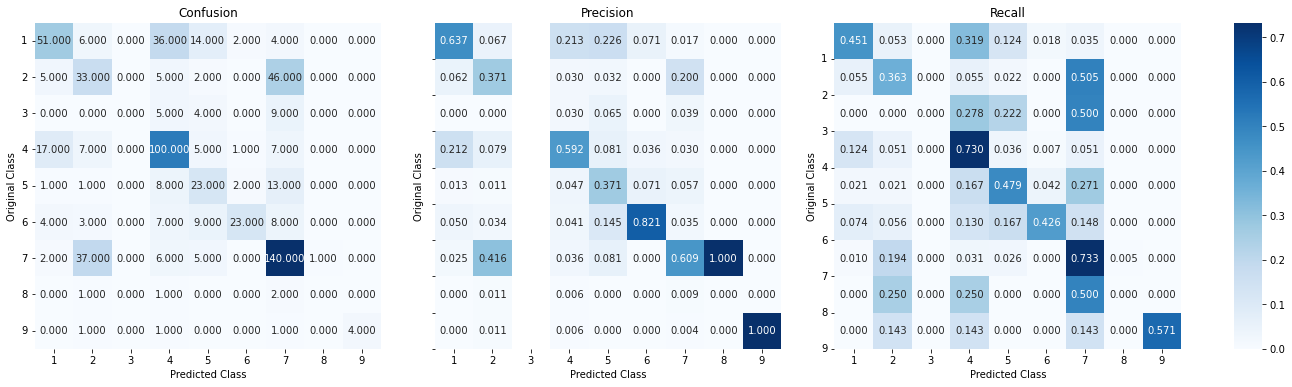

In [32]:
plot_matrices(model_simple, [X_test_gene, X_test_var, X_test_sum], Y_test)

Log loss: 1.4582564717363762
Accuracy: 0.4751131221719457


/tmp/ipykernel_106628/3591071593.py:10: RuntimeWarning: invalid value encountered in true_divide
  precision =(confusion/confusion.sum(axis=0))


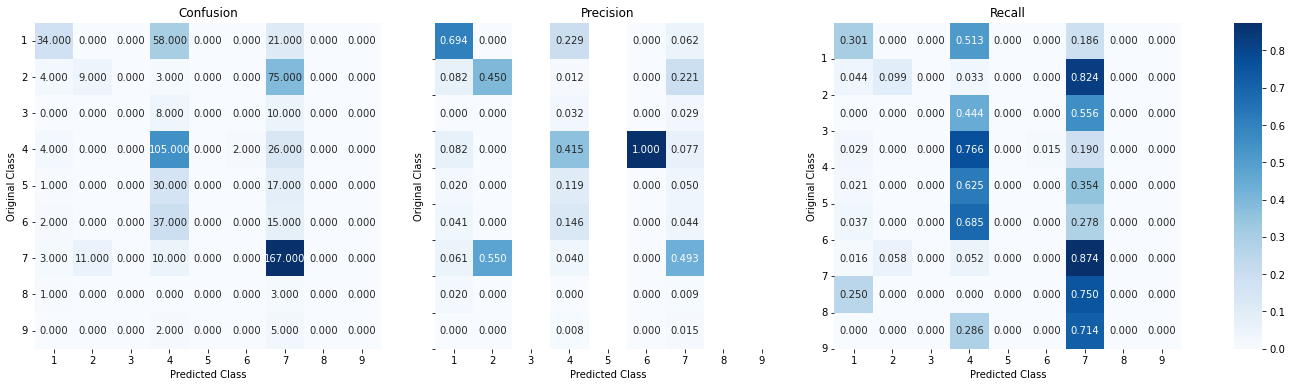

In [33]:
plot_matrices(model_complex, [X_test_gene, X_test_var, X_test_sum], Y_test)